# Introduction 

This tutorial is going to show the findexgram method for machinery fault diagnosis. 

We take the Gini index as an example. Other indexes can be used by simply replacing the name of the Gini index. 


## Data

 We are going to use the well-known [CWRU Bearing Dataset](https://engineering.case.edu/bearingdatacenter).
 
In particular, an outer race fault data belonging to the [12k Drive End Bearing Fault](https://engineering.case.edu/bearingdatacenter/12k-drive-end-bearing-fault-data) is used. 

# Findexgram for Fault Diagnosis

## Import Packages

In [1]:
# ----- standard packages
import numpy as np
import matplotlib.pyplot as plt
import os
# ----- findexgram and the fault index function 
from dbtpy.filters.findexgram import findexgram
from dbtpy.findexes.afindex import findex_fun
# ----- save and read
from dbtpy.tools.file_tools import get_time, save_dict, read_dict
# ----- visulizatioin 
from dbtpy.filters.findexgram import nextpow2
from dbtpy.tools.visual_tools import show_ses_xy, show_heatmap
# ----- data 
from dbtpy.data.CWRU.cwru_data import CWRU_Data 
# ----- quantitative analysis
from dbtpy.findexes.harmonics import harEstimation, vanillaSNR, harkurtosis, CHNR


## Load Data

In [2]:
##########################################################################
# ---------------------------- CWRU_Data ----------------------------------
data = CWRU_Data()
sig_kargs={}
sig_kargs['fault_str'] = '147.mat'
sig_kargs['fs'] = 12e3
sig_kargs['position'] = 'DE'
sig_kargs['resolution'] = 1
sig_kargs['path'] = r'E:\CityU\CWRU\12k Drive End Bearing Fault Data1\out'
sig = data.load(**sig_kargs)

## Define the Fault Index

In [3]:
##########################################################################
#--------------------------------------------------------------------------
#-- define the fault index dictionary
findexBase = 'gini' # the base fault index 
sigD = 'env' # the signal domain for calculating the fault index 

findex_dict ={'findex_fun':findex_fun,                      
                  'findex_kwargs':{'findexBase':findexBase, 
                                    'sigD':sigD}
                  }

## Information You Want to Save

In [4]:
###########################################################################
#-- save important information into the dictionary
path=r'tutorial\findexgram_diag'

alg_save_dict = {}
alg_save_dict['alg_name'] = 'findexgram_'+findexBase + '_' + sigD 
alg_save_dict['findex_str'] = findexBase + '_' + sigD 
alg_save_dict['save_path'] =  path
alg_save_dict['save_fileName'] = {}
alg_save_dict['save_fileName']['dict'] ='dict_'+ alg_save_dict['alg_name'] +'_'+ get_time() + '.txt'
alg_save_dict['save_fileName']['ses'] = 'ses_'+alg_save_dict['alg_name']  +'_'+ get_time() + '.png'
alg_save_dict['save_fileName']['heatmap'] = 'heatmap_'+alg_save_dict['alg_name'] +'_'+ get_time() + '.png'

#-- sig info.
alg_save_dict['sig_fs'] = data.fs # sampling frequency
alg_save_dict['sig'] = sig.tolist()
alg_save_dict['sig_path'] = sig_kargs['path']
alg_save_dict['sig_opt'] = {'findex':[], # fault index
                            'level':[],  # tree level
                            'Bw':[],     # bandwidth
                            'fc':[],     # central frequency (should multiply by fs to show the result)  
                            'sig_c':[],  # complex signal
                            'ses_x':[],  # value of ses_horizonal axis
                            'ses_y':[],  # value of ses_vertical axis
                            'Kwav':[],   # value of fault index in the findexgram
                            'freq_w':[], # x-axis of the findexgram
                            'Level_w':[],# y-axis of the findexgram
                            'nlevel':[], # maximum level
                            'f_target':[]} # target frequency

## Run the Algorithm 

In [5]:
###########################################################################
#-- diagnosis  

# determine maximum level based on the minimun bandwidth required
minB = 6*data.f_target # the rule of thumb: 3-6 times of the fault frequency 
for i in range(int(np.floor(np.log2(len(sig))))):
    if minB * 2**i > 0.5 * data.fs:
        break
nlevel = i-1

#-- get the optimal signal, here the complex_subsig has been downsampled
#-- please refer to the paper of fast kurtorgam  for more details
([M, lev, Bw, fc], [c, ses_x, ses_y], [Kwav, freq_w, Level_w] ) = findexgram(sig = sig, nlevel = nlevel, 
                                                                              findex_dict = findex_dict, 
                                                                              fs = data.fs ) 

## Save Information 

In [6]:
###########################################################################
#-- save for visualization
#--------------------------------------------------------------------------
#-- save info. of optimal signal
alg_save_dict['sig_opt'] = {'findex':M, # the maximum fault index
                            'level':lev, # tree level of the  maximum fault index
                            'Bw':Bw,     # bandwidth of the  maximum fault index
                            'fc':fc,     # central frequency of the  maximum fault index                           
                            'sig_c':c.tolist(),  # complex signal
                            'ses_x':ses_x.tolist(),  # value of ses_horizonal axis
                            'ses_y':ses_y.tolist(),  # value of ses_vertical axis
                            'Kwav':Kwav.tolist(),   # value of fault index in the findexgram
                            'freq_w':freq_w.tolist(), # x-axis of the findexgram
                            'Level_w':Level_w.tolist(), # # y-axis of the findexgram
                            'nlevel':nlevel, # the number tree level 
                            'f_target':data.f_target} # the fault frequency 

#--------------------------------------------------------------------------
#-- save results
savePath_dict = os.path.join(alg_save_dict['save_path'], alg_save_dict['save_fileName']['dict'] )
save_dict(alg_save_dict,  savePath_dict )

## Visualization 

### Show the Optimal Band on the Heat-map

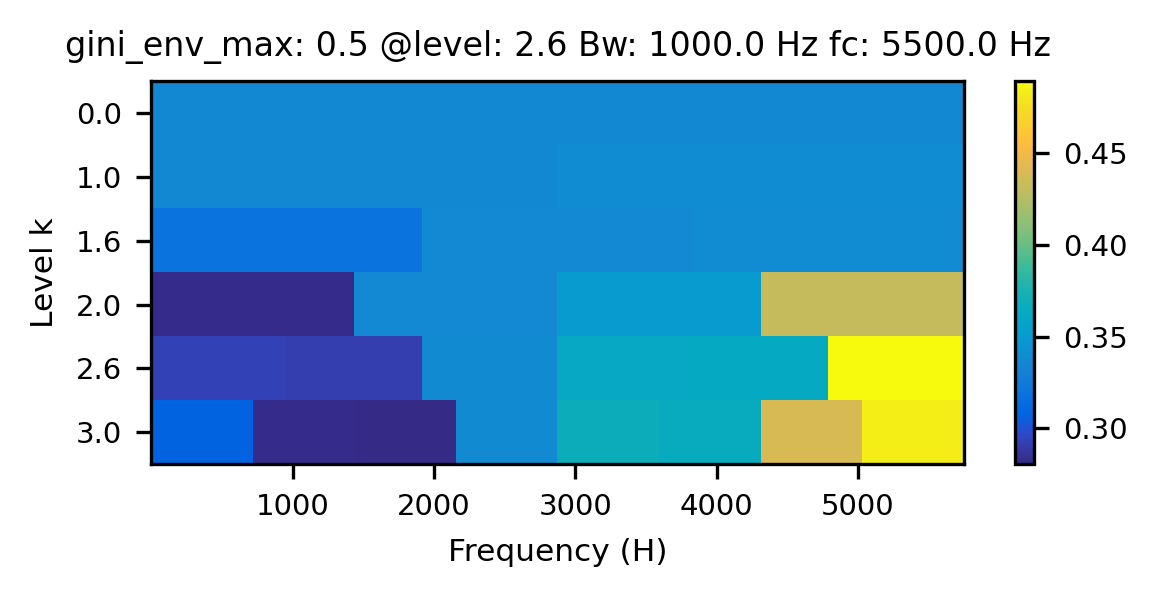

In [7]:
# ###############################################################################
# #----------------------------- findexgram based 
# # ---- findexgram
# # -- sk
dict_read = read_dict(savePath_dict ) #
sig_name = 'sig_opt'

ses_x = dict_read['sig_opt']['ses_x']
ses_y = dict_read['sig_opt']['ses_y']
ses_y_temp = np.array(ses_y)

#------------------------------ 1/3-binary tree 
Kwav = dict_read['sig_opt']['Kwav']
freq_w = dict_read['sig_opt']['freq_w']
Level_w = dict_read['sig_opt']['Level_w']
nlevel = dict_read['sig_opt']['nlevel']
fs = data.fs
findex_str = dict_read['findex_str']

plt.close('all')
show_heatmap(Kwav, freq_w, Level_w, nlevel, fs, findex_str, figsize = (4, 2), dpi = 300,
                fig_format = 'png', fontsize = 7 ,
             fig_save_path = os.path.join(dict_read['save_path'], dict_read['save_fileName']['heatmap']))

### Show the Squared Envelope Spectrum (SES)

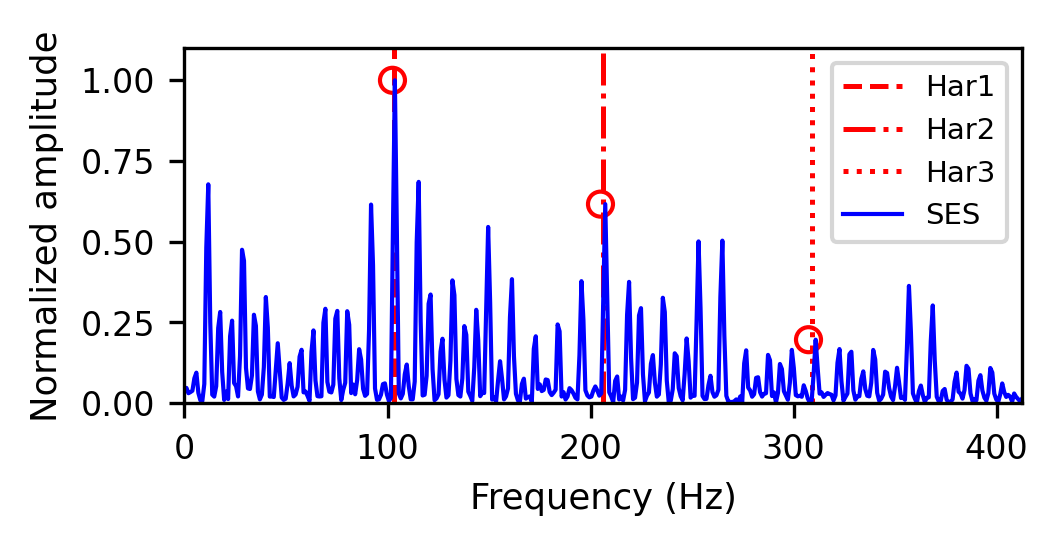

In [8]:

nfft = int(nextpow2(len(ses_x))) 
fre2seq =2*nfft * 2 **dict_read['sig_opt']['level'] / data.fs

#-- for harmonic estimation
dev1 = 0.025

#------------------------------  ses 
show_ses_xy(ses_x, ses_y_temp,fs=data.fs, SSES=False, dpi=300,fre2seq = fre2seq,
             f_target=data.f_target , dev1 = dev1,
             fig_save_path = os.path.join(dict_read['save_path'], dict_read['save_fileName']['ses']))


## Quantitative Analysis

In [9]:
# ###############################################################################
#------------------------------ quantative analysis
#------------------------------ We consider the first three fault harmonics in the normalized SES
#-- the mean amplitude 
A_amps, _ = harEstimation(seq=ses_y_temp,f_target=data.f_target, harN = 3, fs=data.fs, dev1 = dev1, 
                   sig_len_original = None, fre2seq = fre2seq)
A_amps_norm = A_amps / max(ses_y_temp)
A_mean_amp = np.mean(A_amps_norm)

#-- the vanilla signal to noise ratio
A_vanSNR = vanillaSNR(seq=ses_y_temp,f_target=data.f_target, harN = 3, fs=data.fs, dev1 = dev1, 
                  sig_len_original = None, fre2seq = fre2seq)
#-- the harmonic kurtosis 
A_harkurt = harkurtosis(seq=ses_y_temp,f_target=data.f_target, harN = 3, fs=data.fs, dev1 = dev1, 
                  sig_len_original = None, fre2seq = fre2seq)
#-- the cyclic harmonic to noise ratio 
A_chnr=CHNR(seq=ses_y_temp,f_target=data.f_target, harN = 3, fs=data.fs, dev1 = dev1, 
                 sig_len_original = None, fre2seq = fre2seq)

print('\n')
print('mean amplitude = ', round(A_mean_amp, 2))
print('vanilla SNR = ', round(A_vanSNR, 2))
print('harmonic kurt = ', round(A_harkurt, 2))
print('CHNR = ', round(A_chnr, 2))
# ###############################################################################



mean amplitude =  0.6
vanilla SNR =  -12.1
harmonic kurt =  6.51
CHNR =  0.12
